Loading necessory packages

In [69]:
import pandas as pd
import numpy as np
import tensorflow as tf

from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm, neural_network
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

import pandas, numpy, string
from keras.preprocessing import text, sequence
from keras import layers, models, optimizers

import warnings
warnings.filterwarnings("ignore") # Ignore warnings

Loading Train dataset ...

In [8]:
df = pd.read_csv('Train.csv')
print('Length of dataset before preprocessing: ', len(df))
print('\n We also have {} different labels/class including {} \n'.format(len(df['Label'].unique()), df['Label'].unique()))

Length of dataset before preprocessing:  1436

 We also have 20 different labels/class including ['POLITICS' 'HEALTH' 'LAW/ORDER' 'RELIGION' 'FARMING'
 'WILDLIFE/ENVIRONMENT' 'SOCIAL ISSUES' 'SOCIAL' 'OPINION/ESSAY'
 'LOCALCHIEFS' 'WITCHCRAFT' 'ECONOMY' 'SPORTS' 'RELATIONSHIPS' 'TRANSPORT'
 'CULTURE' 'EDUCATION' 'MUSIC' 'ARTS AND CRAFTS' 'FLOODING'] 



In [9]:
print('Each sample in raw dataset include a col that contains 15-16 different sentences...\n')
df.head(1500)

Each sample in raw dataset include a col that contains 15-16 different sentences...



,ID,Text,Label
0,ID_AASHwXxg,Mwangonde: Khansala wachinyamata Akamati achi...,POLITICS
1,ID_AGoFySzn,MCP siidakhutire ndi kalembera Chipani cha Ma...,POLITICS
2,ID_AGrrkBGP,Bungwe la MANEPO Lapempha Boma Liganizire Anth...,HEALTH
3,ID_AIJeigeG,Ndale zogawanitsa miyambo zanyanya Si zachile...,POLITICS
4,ID_APMprMbV,Nanga wapolisi ataphofomoka? Masiku ano sichi...,LAW/ORDER
...,...,...,...
1431,ID_zmTmmEio,Eni Minibus Ati Ali ndi Ufulu Wokweza Mitengo ...,TRANSPORT
1432,ID_znOlIaGQ,Kachali apepesa: Kulankhula motumbwa kuthe An...,POLITICS
1433,ID_znracTjN,Mawu supports non-fiction writers The Malawi ...,EDUCATION
1434,ID_ztdsmmva,Tame Mwawa: Phwete ndiye kudya kwake Sewero l...,SOCIAL ISSUES


Generating new table including refID of news agency, sentence in the news, Label of each sentence

In [10]:
X_data = pd.DataFrame(columns=['refID', 'Sentence', 'Label'])
for idx in range(len(df)):
    tmp = df.loc[idx]['Text'].split('\n')
    for jdx in range(len(tmp)):
        X_data = X_data.append({'refID': df.loc[idx]['ID'],'Sentence': tmp[jdx], 'Label': df.loc[idx]['Label']}, ignore_index=True)

preprocessing all samples by changing them to lowercase and erasing punctuations

In [12]:
print('Applying preprocessing steps : Changing all characters to lower-case and removing punctuation')
X_data.loc[:,"Sentence"] = X_data.Sentence.apply(lambda x : str.lower(x))
X_data.loc[:,"Label"] = X_data.Label.apply(lambda x : str.lower(x))
X_data.loc[:,"Sentence"] = X_data.Sentence.str.replace('[^\w\s]','')
X_data.loc[:,"Sentence"] = X_data.Sentence.apply(lambda x : x.translate(string.punctuation))

Applying preprocessing steps : Changing all characters to lower-case and removing punctuation


changing Labels to indecies ...

In [13]:
# label encode the target variable 
encoder = preprocessing.LabelEncoder()
X_data.loc[:,"Label"] = encoder.fit_transform(X_data.Label)

In [14]:
X_data

,refID,Sentence,Label
0,ID_AASHwXxg,mwangonde khansala wachinyamata akamati achin...,11
1,ID_AASHwXxg,mbiri ya maphunziro anu ndi yotani maphunziro...,11
2,ID_AASHwXxg,mudayamba bwanji zandale kuyambira ndili wach...,11
3,ID_AASHwXxg,ntchito mukugwira ndi zomwe munkayembekezera ...,11
4,ID_AASHwXxg,masomphenya anu ndi otani pandale ine ndine m...,11
...,...,...,...
16496,ID_zteydTpN,phiri adati zomwe adakambirana akuluakuluwo a...,11
16497,ID_zteydTpN,mmbuyomu kafukufuku yemwe nyuzipepala ya the ...,11
16498,ID_zteydTpN,mchaka cha 2006 mtsogoleri wa dziko lino pete...,11
16499,ID_zteydTpN,pamsonkhanowo padali a zipani zosiyanasiyana ...,11


split the dataset into training and validation datasets 

In [15]:
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(X_data['Sentence'], X_data['Label'])

approach 1 : encoding words using raw term count features for LDA.

In [16]:
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(X_data['Sentence'])
xtrain_count =  count_vect.transform(train_x)
xvalid_count =  count_vect.transform(valid_x)

approach 2 : encoding words using rExtracting tf-idf features for NMF

In [17]:
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram.fit(X_data['Sentence'])
xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(train_x)
xvalid_tfidf_ngram =  tfidf_vect_ngram.transform(valid_x)

In [18]:
def train_model(classifier, feature_vector_train, label, feature_vector_valid):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    
    return metrics.accuracy_score(predictions, valid_y)

Naive Bayes

In [13]:
# Naive Bayes on Count Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_count, train_y, xvalid_count)
print('NB, Count Vectors: ', accuracy)

# Naive Bayes on Ngram Level TF IDF Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print('NB, N-Gram Vectors: ', accuracy)


NB, Count Vectors:  0.44595249636451767
NB, N-Gram Vectors:  0.3504604944255938


SVM

In [14]:
accuracy = train_model(svm.SVC(), xtrain_count, train_y, xvalid_count)
print('SVM, Count Vectors: ', accuracy)

accuracy = train_model(svm.SVC(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print('SVM, N-Gram Vectors: ', accuracy)

SVM, Count Vectors:  0.43165293262239457
SVM, N-Gram Vectors:  0.33737275811924383


Random Forest

In [15]:
# RF on Count Vectors
accuracy = train_model(ensemble.RandomForestClassifier(), xtrain_count, train_y, xvalid_count)
print('RF, Count Vectors: ', accuracy)

# RF on Word Level TF IDF Vectors
accuracy = train_model(ensemble.RandomForestClassifier(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print('RF, N-Gram Vectors: ', accuracy)

RF, Count Vectors:  0.4590402326708677
RF, N-Gram Vectors:  0.3584585555016966


Logistic Regression

In [70]:
# Logistic Regression on Count Vectors
accuracy = train_model(linear_model.LogisticRegression(), xtrain_count, train_y, xvalid_count)
print('LR, Count Vectors: ', accuracy)

# Logistic Regression on Word Level TF IDF Vectors
accuracy = train_model(linear_model.LogisticRegression(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print('LR, N-Gram Vectors: ', accuracy)

LR, Count Vectors:  0.5547746000969462
LR, N-Gram Vectors:  0.3739699466795928


Neural Network

In [71]:
# Logistic Regression on Count Vectors
accuracy = train_model(neural_network.MLPClassifier(), xtrain_count, train_y, xvalid_count)
print('LR, Count Vectors: ', accuracy)

# Logistic Regression on Word Level TF IDF Vectors
accuracy = train_model(neural_network.MLPClassifier(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print('LR, N-Gram Vectors: ', accuracy)

LR, Count Vectors:  0.5857973824527387
LR, N-Gram Vectors:  0.33446437227338827


In [23]:
print(xtrain_count)

  (0, 705)	1
  (0, 5319)	1
  (0, 7904)	1
  (0, 8497)	1
  (0, 14247)	1
  (0, 14831)	1
  (0, 18339)	1
  (0, 18559)	1
  (0, 20144)	1
  (0, 21950)	1
  (0, 22336)	1
  (0, 22701)	1
  (0, 24916)	1
  (0, 25984)	2
  (0, 28431)	1
  (0, 28756)	1
  (0, 29292)	2
  (0, 32821)	2
  (0, 35086)	3
  (0, 35810)	2
  (0, 44598)	2
  (0, 45296)	2
  (0, 47785)	2
  (1, 2173)	1
  (1, 7936)	1
  :	:
  (12373, 21365)	1
  (12373, 24342)	1
  (12373, 26626)	1
  (12373, 26926)	1
  (12373, 28756)	1
  (12373, 29881)	1
  (12373, 32531)	1
  (12373, 35729)	1
  (12373, 36650)	1
  (12373, 37672)	1
  (12373, 44598)	1
  (12374, 705)	1
  (12374, 9368)	1
  (12374, 9744)	1
  (12374, 25158)	1
  (12374, 25500)	1
  (12374, 35086)	1
  (12374, 35376)	1
  (12374, 35570)	1
  (12374, 43791)	1
  (12374, 43994)	1
  (12374, 44006)	1
  (12374, 47856)	1
  (12374, 48297)	1
  (12374, 50703)	1


In [26]:
print(xtrain_tfidf_ngram)

  (0, 4515)	0.21265636843524072
  (0, 4418)	0.17242691122871398
  (0, 4417)	0.16439858262062082
  (0, 4380)	0.17493709198309398
  (0, 4376)	0.15119794717219978
  (0, 3980)	0.2198515919560118
  (0, 3971)	0.2295717687266814
  (0, 3969)	0.154153823713961
  (0, 3864)	0.38061820568220417
  (0, 3861)	0.319681357577889
  (0, 3816)	0.16244321080109445
  (0, 3814)	0.15853376014850315
  (0, 3546)	0.3159837212762862
  (0, 2777)	0.16957678873041598
  (0, 2773)	0.12622236465900158
  (0, 2742)	0.15234300822161265
  (0, 2740)	0.14703666163681955
  (0, 2216)	0.18285619560674068
  (0, 2215)	0.17428806394232454
  (0, 1391)	0.1746106912107693
  (0, 1390)	0.1739691239233932
  (0, 1153)	0.2295717687266814
  (0, 1089)	0.17428806394232454
  (0, 1087)	0.15542979214417638
  (1, 4693)	0.4602596890563726
  :	:
  (12369, 448)	0.29365848430272046
  (12370, 4739)	0.41950866844672596
  (12370, 4596)	0.42934564409487963
  (12370, 1705)	0.5518349227285468
  (12370, 1704)	0.46481172009805294
  (12370, 1262)	0.345113137

In [33]:
#A: XTrain
xtrain_count
print(xtrain_count.shape)

(12375, 51137)


In [34]:
#B: XTrain
xtrain_tfidf_ngram
print(xtrain_tfidf_ngram.shape)

(12375, 5000)


In [45]:
#Y Train for Both
print(train_y)
print(train_y.shape)

2982     13
8473      2
8357      7
9756     11
5978     12
         ..
7884     11
12172    11
1766      7
2785     11
3521     13
Name: Label, Length: 12375, dtype: int32
(12375,)


In [44]:
#A: X Valid
xvalid_count
print(xvalid_count.shape)

(4126, 51137)


In [43]:
#B: X Valid
xvalid_tfidf_ngram
print(xvalid_tfidf_ngram.shape)

(4126, 5000)


In [65]:
#Version A:
report = poly(xtrain_tfidf_ngram,train_y, n_folds=3, verbose=True, save=False, scale=True,
              feature_selection=False, scoring='auc', concurrency=1, exclude=['Multilayer Perceptron', 'SVM', 'Linear SVM'])

2021-04-17 19:27:08,319 - polyssifier - INFO - Building classifiers ...
2021-04-17 19:27:08,370 - polyssifier - INFO - Initialization, done.
2021-04-17 19:27:09,111 - polyssifier - INFO - Training Nearest Neighbors 0


ValueError: Cannot center sparse matrices: pass `with_mean=False` instead. See docstring for motivation and alternatives.

In [40]:
from sklearn import datasets
from polyssifier import poly
import numpy as np
import pandas as pd
from sklearn.datasets import make_moons, make_classification
import matplotlib.pyplot as plt 
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

(500, 2)
(500,)


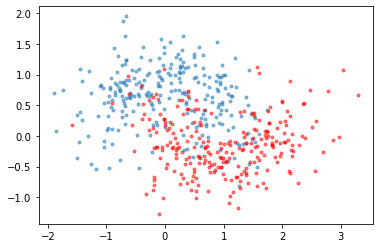

In [41]:
data, label = make_moons(n_samples=500, noise=0.4)
print(data.shape)
print(label.shape)

plt.plot(data[label==0,0], data[label==0,1],'.', alpha=.5);
plt.plot(data[label==1,0], data[label==1,1],'r.', alpha=.5);

2021-04-17 19:19:31,497 - polyssifier - INFO - Building classifiers ...
2021-04-17 19:19:31,537 - polyssifier - INFO - Initialization, done.
2021-04-17 19:19:32,200 - polyssifier - INFO - Training Nearest Neighbors 0
2021-04-17 19:19:32,375 - polyssifier - INFO - Nearest Neighbors          0: Train 0.93/Test 0.94, 0.17 sec
2021-04-17 19:19:32,378 - polyssifier - INFO - Training Nearest Neighbors 1
2021-04-17 19:19:32,534 - polyssifier - INFO - Nearest Neighbors          1: Train 0.95/Test 0.91, 0.16 sec
2021-04-17 19:19:32,539 - polyssifier - INFO - Training Nearest Neighbors 2
2021-04-17 19:19:32,678 - polyssifier - INFO - Nearest Neighbors          2: Train 0.94/Test 0.91, 0.14 sec
2021-04-17 19:19:32,682 - polyssifier - INFO - Training SVM 0
2021-04-17 19:19:32,999 - polyssifier - INFO - SVM                        0: Train 0.91/Test 0.92, 0.32 sec
2021-04-17 19:19:33,003 - polyssifier - INFO - Training SVM 1
2021-04-17 19:19:33,347 - polyssifier - INFO - SVM                        1

predict proba return shape (167,)
predict proba return shape (167,)


2021-04-17 19:19:34,118 - polyssifier - INFO - Linear SVM                 2: Train 0.90/Test 0.90, 0.14 sec
2021-04-17 19:19:34,122 - polyssifier - INFO - Training Decision Tree 0
2021-04-17 19:19:34,144 - polyssifier - INFO - Decision Tree              0: Train 1.00/Test 0.81, 0.02 sec
2021-04-17 19:19:34,150 - polyssifier - INFO - Training Decision Tree 1
2021-04-17 19:19:34,169 - polyssifier - INFO - Decision Tree              1: Train 1.00/Test 0.81, 0.02 sec
2021-04-17 19:19:34,173 - polyssifier - INFO - Training Decision Tree 2
2021-04-17 19:19:34,194 - polyssifier - INFO - Decision Tree              2: Train 1.00/Test 0.77, 0.02 sec
2021-04-17 19:19:34,199 - polyssifier - INFO - Training Random Forest 0


predict proba return shape (166,)


2021-04-17 19:19:36,168 - polyssifier - INFO - Random Forest              0: Train 1.00/Test 0.92, 1.97 sec
2021-04-17 19:19:36,178 - polyssifier - INFO - Training Random Forest 1
2021-04-17 19:19:38,456 - polyssifier - INFO - Random Forest              1: Train 1.00/Test 0.88, 2.28 sec
2021-04-17 19:19:38,478 - polyssifier - INFO - Training Random Forest 2
2021-04-17 19:19:41,363 - polyssifier - INFO - Random Forest              2: Train 1.00/Test 0.87, 2.88 sec
2021-04-17 19:19:41,375 - polyssifier - INFO - Training Logistic Regression 0
2021-04-17 19:19:41,515 - polyssifier - INFO - Logistic Regression        0: Train 0.90/Test 0.91, 0.14 sec
2021-04-17 19:19:41,520 - polyssifier - INFO - Training Logistic Regression 1
2021-04-17 19:19:41,670 - polyssifier - INFO - Logistic Regression        1: Train 0.90/Test 0.90, 0.15 sec
2021-04-17 19:19:41,676 - polyssifier - INFO - Training Logistic Regression 2
2021-04-17 19:19:41,830 - polyssifier - INFO - Logistic Regression        2: Train

                               mean       std       min       max
Nearest Neighbors   train  0.940450  0.007107  0.933410  0.947623
                    test   0.920154  0.016964  0.906411  0.939114
SVM                 train  0.925289  0.009121  0.914761  0.930797
                    test   0.916352  0.006629  0.910643  0.923623
Linear SVM          train  0.903363  0.001563  0.901703  0.904805
                    test   0.903208  0.006125  0.897663  0.909782
Decision Tree       train  1.000000  0.000000  1.000000  1.000000
                    test   0.797739  0.023274  0.771084  0.814042
Random Forest       train  0.999401  0.000331  0.999068  0.999729
                    test   0.892497  0.026662  0.873131  0.922906
Logistic Regression train  0.903315  0.001582  0.901630  0.904769
                    test   0.903401  0.006058  0.897953  0.909925
Naive Bayes         train  0.903314  0.002061  0.900945  0.904697
                    test   0.902871  0.007197  0.897082  0.910929
Voting    

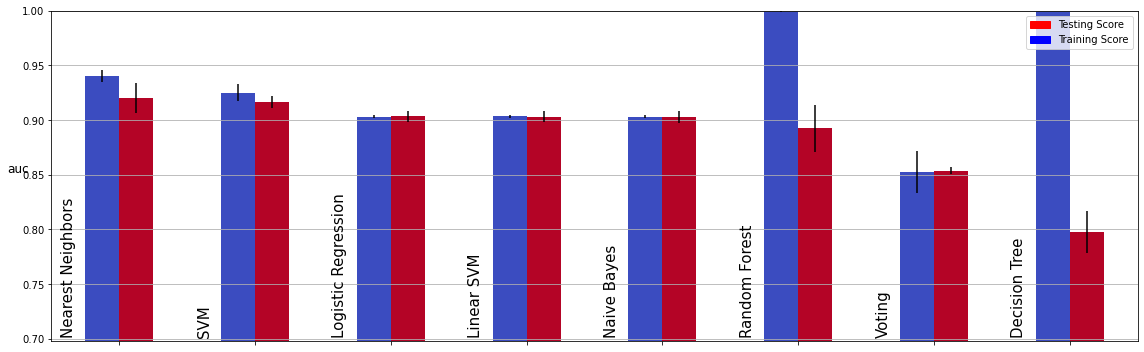

In [42]:
report = poly(data,label, n_folds=3, verbose=True, save=False, scale=True,
              feature_selection=False, scoring='auc', concurrency=1, exclude=['Multilayer Perceptron'])
report.plot_scores()